In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import process_time
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [ ]:
bucket = 'andrew-data-sagemaker/WeatherClassifier'
data_key = 'WeatherAusReady.csv' 
data_location = 's3://{}/{}'.format(bucket, data_key) 
weather_df = pd.read_csv(data_location)
weather_df.head()

In [2]:
data_location = 'data/weatherAUSReady.csv'
weather_df = pd.read_csv(data_location)
weather_df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,id
0,0,2008-12-01,Albury,13.4,22.9,0.6,5.1,10.9,W,44.0,...,1007.7,1007.1,8.0,6.2,16.9,21.8,0.0,0.0,No,1
1,1,2008-12-02,Albury,7.4,25.1,0.0,5.1,10.9,WNW,44.0,...,1010.6,1007.8,2.9,6.2,17.2,24.3,0.0,0.0,No,2
2,2,2008-12-03,Albury,12.9,25.7,0.0,5.1,10.9,WSW,46.0,...,1007.6,1008.7,2.9,2.0,21.0,23.2,0.0,0.0,No,3
3,3,2008-12-04,Albury,9.2,28.0,0.0,5.1,10.9,NE,24.0,...,1017.6,1012.8,2.9,6.2,18.1,26.5,0.0,1.0,No,4
4,4,2008-12-05,Albury,17.5,32.3,1.0,5.1,10.9,W,41.0,...,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.2,No,5


# Final Variables

We dummies the seasons because it is a categorical numerical variable where a number isn't better than the other. We also drop unnecessary columns such as Wind Direction and RISK_MM.

In [11]:
weather_df = pd.concat([weather_df, pd.get_dummies(weather_df['Seasons'], prefix="Seasons"), 
                        pd.get_dummies(weather_df['Location'], prefix="Location")], axis = 1)
weather_df.drop(['Seasons', 'Location', 'RISK_MM', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
                 'Year', 'Month', 'Date', 'Unnamed: 0', 'id'], axis=1, inplace=True)

In [12]:
weather_df.RainToday.value_counts()

0.0    110738
1.0     31455
Name: RainToday, dtype: int64

In [13]:
weather_df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Seasons_1',
       'Seasons_2', 'Seasons_3', 'Seasons_4', 'Location_Adelaide',
       'Location_Albany', 'Location_Albury', 'Location_AliceSprings',
       'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo',
       'Location_Brisbane', 'Location_Cairns', 'Location_Canberra',
       'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor',
       'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart',
       'Location_Katherine', 'Location_Launceston', 'Location_Melbourne',
       'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree',
       'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle',
       'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland',

# Reclusive Feature elimination 

As there is so many varibles and most likely some variables do not contribute to the model well, we will be applying Reclusive Feature Elimination - Logistic Regression. This is applying Logistic Regression modelling but with elimination of features. 

In [14]:
target = 'RainTomorrow'
features = [col for col in weather_df.columns if col != target]
logreg = LogisticRegression()
X = weather_df[features]
y = weather_df[target]
rfe = RFE(logreg, 50)
rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True False False False  True  True False False False  True  True  True
 False  True False False  True  True False  True False  True  True  True
 False  True  True  True  True  True  True  True  True False  True  True
  True  True  True False  True False  True False  True  True False  True
  True False  True  True  True  True False  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True]
[ 1 21 13 18  1  1 20  8 19  1  1  1  4  1 11 15  1  1 14  1  7  1  1  1
  5  1  1  1  1  1  1  1  1  2  1  1  1  1  1 12  1  9  1  6  1  1 10  1
  1  3  1  1  1  1 16  1  1  1  1  1  1  1 17  1  1  1  1  1  1  1]


In [15]:
rfe_ranks = rfe.ranking_.tolist()
len(rfe_ranks)

70

In [16]:
rfe_table = pd.DataFrame({'features':features, 'ranks':rfe_ranks})
rfe_table = rfe_table.loc[rfe_table['ranks'] == 1]
rfe_features = rfe_table.features.tolist()

In [17]:
len(features)

70

In [18]:
lgr_rfe_weather_df = pd.concat([weather_df[rfe_features], weather_df.RainTomorrow], axis=1)

# Logistic Regression with RFE

Using the features from RFE, we will create a logistic regression model and then 10-fold cross validate it.

In [19]:
X,y = lgr_rfe_weather_df.iloc[:,lgr_rfe_weather_df.columns != 'RainTomorrow'], lgr_rfe_weather_df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [20]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.84
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     22098
           1       0.72      0.49      0.58      6341

    accuracy                           0.84     28439
   macro avg       0.79      0.72      0.74     28439
weighted avg       0.83      0.84      0.83     28439



In [21]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', TP)
print('\nTrue Negatives(TN) = ', TN )
print('\nFalse Positives(FP) = ', FP)
print('\nFalse Negatives(FN) = ', FN )

Confusion matrix

 [[20856  1242]
 [ 3225  3116]]

True Positives(TP) =  20856

True Negatives(TN) =  3116

False Positives(FP) =  1242

False Negatives(FN) =  3225


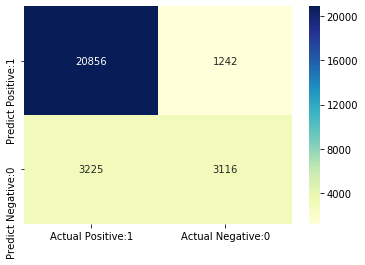

In [22]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [23]:
precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))
recall = TP / float(TP + FN)
print('Recall : {0:0.4f}'.format(recall))
f1score = 2 *( (precision * recall)/ (precision + recall))
print('F1-score : {0:0.4f}'.format(f1score))

Precision : 0.9438
Recall : 0.8661
F1-score : 0.9033


In [24]:
lgr_rfe_scores = []
lgr_rfe_recalls = []
lgr_rfe_precisions = []
kf = KFold(10, True)
temp_cv_scores = []
cv_lgr_rfe = LogisticRegression()
for train, test in kf.split(X):
    X_train, X_test = X.values[train], X.values[test]
    y_train, y_test = y.values[train], y.values[test]
    cv_lgr_rfe.fit(X_train, y_train)
    y_pred = cv_lgr_rfe.predict(X_test)
    precision, recall, fscore, support = score(y_pred, y_test)
    lgr_rfe_scores.append(fscore)
    lgr_rfe_recalls.append(recall)
    lgr_rfe_precisions.append(precision)
print('Score:', sum(lgr_rfe_scores) / len(lgr_rfe_scores), 'Recall:', sum(lgr_rfe_recalls) / len(lgr_rfe_recalls), 
      'Precision:', sum(lgr_rfe_precisions) / len(lgr_rfe_precisions))

Score: [0.90374847 0.58156787] Recall: [0.86423954 0.72587376] Precision: [0.94705094 0.48519092]


In [25]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', TP)
print('\nTrue Negatives(TN) = ', TN )
print('\nFalse Positives(FP) = ', FP)
print('\nFalse Negatives(FN) = ', FN )

Confusion matrix

 [[10469   593]
 [ 1644  1513]]

True Positives(TP) =  10469

True Negatives(TN) =  1513

False Positives(FP) =  593

False Negatives(FN) =  1644


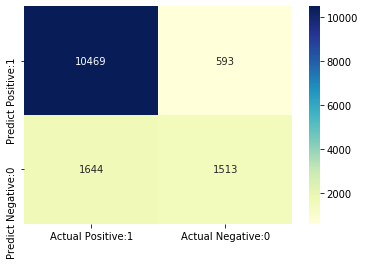

In [26]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [27]:
precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))
recall = TP / float(TP + FN)
print('Recall : {0:0.4f}'.format(recall))
f1score = 2 *( (precision * recall)/ (precision + recall))
print('F1-score : {0:0.4f}'.format(f1score))

Precision : 0.9464
Recall : 0.8643
F1-score : 0.9035


# Logistic Regression without RFE

This is similar to the RFE Logistic Regression however we will be using all features rather than the features from RFE. This is to test if the RFE is necessary to improve the results

In [28]:
X,y = weather_df.iloc[:,weather_df.columns != 'RainTomorrow'], weather_df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [29]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.84
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     22098
           1       0.72      0.49      0.59      6341

    accuracy                           0.84     28439
   macro avg       0.79      0.72      0.74     28439
weighted avg       0.83      0.84      0.83     28439



In [30]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', TP)
print('\nTrue Negatives(TN) = ', TN )
print('\nFalse Positives(FP) = ', FP)
print('\nFalse Negatives(FN) = ', FN )

Confusion matrix

 [[20856  1242]
 [ 3205  3136]]

True Positives(TP) =  20856

True Negatives(TN) =  3136

False Positives(FP) =  1242

False Negatives(FN) =  3205


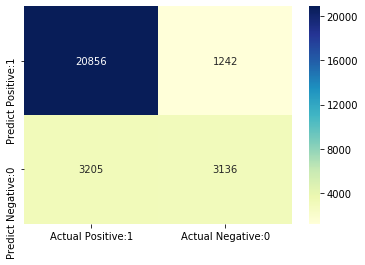

In [31]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [32]:
precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))
recall = TP / float(TP + FN)
print('Recall : {0:0.4f}'.format(recall))
f1score = 2 *( (precision * recall)/ (precision + recall))
print('F1-score : {0:0.4f}'.format(f1score))

Precision : 0.9438
Recall : 0.8668
F1-score : 0.9037


In [33]:
lgr_scores = []
lgr_recalls = []
lgr_precisions = []
kf = KFold(10, True)
temp_cv_scores = []
cv_lgr = LogisticRegression()
for train, test in kf.split(X):
    X_train, X_test = X.values[train], X.values[test]
    y_train, y_test = y.values[train], y.values[test]
    cv_lgr.fit(X_train, y_train)
    y_pred = cv_lgr.predict(X_test)
    precision, recall, fscore, support = score(y_pred, y_test)
    lgr_scores.append(fscore)
    lgr_recalls.append(recall)
    lgr_precisions.append(precision)
print('Score:', sum(lgr_scores) / len(lgr_scores), 'Recall:', sum(lgr_recalls) / len(lgr_recalls), 
      'Precision:', sum(lgr_precisions) / len(lgr_precisions))

Score: [0.90528982 0.59031101] Recall: [0.86646344 0.73242404] Precision: [0.94776932 0.49449098]


In [34]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', TP)
print('\nTrue Negatives(TN) = ', TN )
print('\nFalse Positives(FP) = ', FP)
print('\nFalse Negatives(FN) = ', FN )

Confusion matrix

 [[10477   572]
 [ 1611  1559]]

True Positives(TP) =  10477

True Negatives(TN) =  1559

False Positives(FP) =  572

False Negatives(FN) =  1611


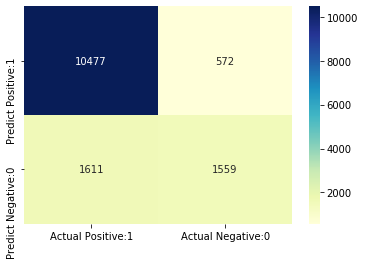

In [35]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [36]:
precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))
recall = TP / float(TP + FN)
print('Recall : {0:0.4f}'.format(recall))
f1score = 2 *( (precision * recall)/ (precision + recall))
print('F1-score : {0:0.4f}'.format(f1score))

Precision : 0.9482
Recall : 0.8667
F1-score : 0.9056


# RFE - XGboost

Same test as the LGR RFE.

In [37]:
target = 'RainTomorrow'
features = [col for col in weather_df.columns if col != target]
xgboost = XGBClassifier()
X = weather_df[features]
y = weather_df[target]
rfe = RFE(xgboost, 50)
rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True False  True  True  True  True  True
 False  True  True False  True False False False  True False False  True
  True  True False  True  True False False False  True False False  True
 False  True  True  True  True False False False  True  True  True False
  True  True  True  True  True  True  True  True  True  True]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 18  1 10  1  1  1  1  1
  2  1  1  3  1  7 11 13  1 19 21  1  1  1  8  1  1 14 15 12  1 17 20  1
 16  1  1  1  1  9  6  5  1  1  1  4  1  1  1  1  1  1  1  1  1  1]


In [38]:
rfe_ranks = rfe.ranking_.tolist()
len(rfe_ranks)

70

In [39]:
rfe_table = pd.DataFrame({'features':features, 'ranks':rfe_ranks})
rfe_table = rfe_table.loc[rfe_table['ranks'] == 1]
rfe_features = rfe_table.features.tolist()

In [40]:
xgb_rfe_weather_df = pd.concat([weather_df[rfe_features], weather_df.RainTomorrow], axis=1)

In [41]:
X,y = xgb_rfe_weather_df.iloc[:,xgb_rfe_weather_df.columns != 'RainTomorrow'], xgb_rfe_weather_df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [42]:
xgboost_model = XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=6, subsample = 0.7, objective= 'binary:logistic')
xgboost_model.fit(X_train, y_train)
xgboost_predictions = xgboost_model.predict(X_test)
print(classification_report(y_test, xgboost_predictions))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     22098
           1       0.74      0.57      0.64      6341

    accuracy                           0.86     28439
   macro avg       0.81      0.76      0.78     28439
weighted avg       0.85      0.86      0.85     28439



In [43]:
cm = confusion_matrix(y_test, xgboost_predictions)
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', TP)
print('\nTrue Negatives(TN) = ', TN )
print('\nFalse Positives(FP) = ', FP)
print('\nFalse Negatives(FN) = ', FN )

Confusion matrix

 [[20849  1249]
 [ 2739  3602]]

True Positives(TP) =  20849

True Negatives(TN) =  3602

False Positives(FP) =  1249

False Negatives(FN) =  2739


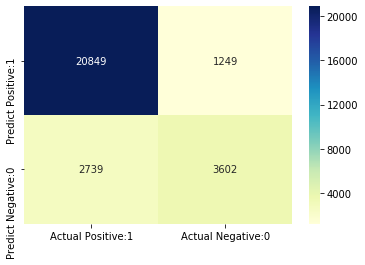

In [44]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [45]:
precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))
recall = TP / float(TP + FN)
print('Recall : {0:0.4f}'.format(recall))
f1score = 2 *( (precision * recall)/ (precision + recall))
print('F1-score : {0:0.4f}'.format(f1score))

Precision : 0.9435
Recall : 0.8839
F1-score : 0.9127


In [46]:
xgb_rfe_scores = []
xgb_rfe_recalls = []
xgb_rfe_precisions = []
kf = KFold(10, True)
temp_cv_scores = []
cv_xgb_rfe = LogisticRegression()
for train, test in kf.split(X):
    X_train, X_test = X.values[train], X.values[test]
    y_train, y_test = y.values[train], y.values[test]
    cv_xgb_rfe.fit(X_train, y_train)
    y_pred = cv_xgb_rfe.predict(X_test)
    precision, recall, fscore, support = score(y_pred, y_test)
    xgb_rfe_scores.append(fscore)
    xgb_rfe_recalls.append(recall)
    xgb_rfe_precisions.append(precision)
print('Score:', sum(xgb_rfe_scores) / len(xgb_rfe_scores), 'Recall:', sum(xgb_rfe_recalls) / len(xgb_rfe_recalls), 
      'Precision:', sum(xgb_rfe_precisions) / len(xgb_rfe_precisions))

Score: [0.90418677 0.58117879] Recall: [0.86384093 0.73045566] Precision: [0.94850105 0.48268822]


In [47]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', TP)
print('\nTrue Negatives(TN) = ', TN )
print('\nFalse Positives(FP) = ', FP)
print('\nFalse Negatives(FN) = ', FN )

Confusion matrix

 [[10422   574]
 [ 1724  1499]]

True Positives(TP) =  10422

True Negatives(TN) =  1499

False Positives(FP) =  574

False Negatives(FN) =  1724


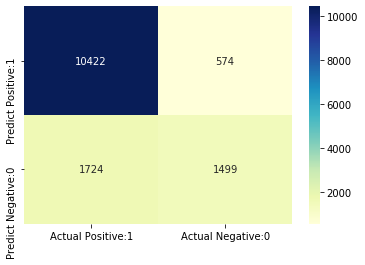

In [48]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [49]:
precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))
recall = TP / float(TP + FN)
print('Recall : {0:0.4f}'.format(recall))
f1score = 2 *( (precision * recall)/ (precision + recall))
print('F1-score : {0:0.4f}'.format(f1score))

Precision : 0.9478
Recall : 0.8581
F1-score : 0.9007


# XGBoost 

Same test as the LGR.

In [50]:
X,y = weather_df.iloc[:,weather_df.columns != 'RainTomorrow'], weather_df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [51]:
xgboost_model = XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=6, subsample = 0.7, objective= 'binary:logistic')
xgboost_model.fit(X_train, y_train)
xgboost_predictions = xgboost_model.predict(X_test)
print(classification_report(y_test, xgboost_predictions))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     22098
           1       0.75      0.57      0.65      6341

    accuracy                           0.86     28439
   macro avg       0.82      0.76      0.78     28439
weighted avg       0.85      0.86      0.86     28439



In [52]:
cm = confusion_matrix(y_test, xgboost_predictions)
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', TP)
print('\nTrue Negatives(TN) = ', TN )
print('\nFalse Positives(FP) = ', FP)
print('\nFalse Negatives(FN) = ', FN )

Confusion matrix

 [[20870  1228]
 [ 2698  3643]]

True Positives(TP) =  20870

True Negatives(TN) =  3643

False Positives(FP) =  1228

False Negatives(FN) =  2698


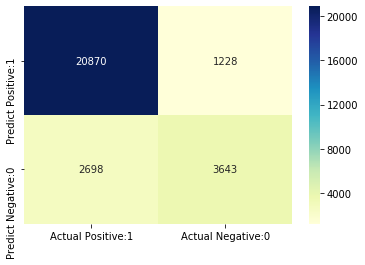

In [53]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [54]:
precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))
recall = TP / float(TP + FN)
print('Recall : {0:0.4f}'.format(recall))
f1score = 2 *( (precision * recall)/ (precision + recall))
print('F1-score : {0:0.4f}'.format(f1score))

Precision : 0.9444
Recall : 0.8855
F1-score : 0.9140


In [55]:
xgb_scores = []
xgb_recalls = []
xgb_precisions = []
kf = KFold(10, True)
temp_cv_scores = []
cv_xgb = LogisticRegression()
for train, test in kf.split(X):
    X_train, X_test = X.values[train], X.values[test]
    y_train, y_test = y.values[train], y.values[test]
    cv_xgb.fit(X_train, y_train)
    y_pred = cv_xgb.predict(X_test)
    precision, recall, fscore, support = score(y_pred, y_test)
    xgb_scores.append(fscore)
    xgb_recalls.append(recall)
    xgb_precisions.append(precision)
print('Score:', sum(xgb_scores) / len(xgb_scores), 'Recall:', sum(xgb_recalls) / len(xgb_recalls), 
      'Precision:', sum(xgb_precisions) / len(xgb_precisions))

Score: [0.90515105 0.5894266 ] Recall: [0.86620033 0.7319674 ] Precision: [0.94777355 0.49338813]


In [56]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', TP)
print('\nTrue Negatives(TN) = ', TN )
print('\nFalse Positives(FP) = ', FP)
print('\nFalse Negatives(FN) = ', FN )

Confusion matrix

 [[10452   559]
 [ 1630  1578]]

True Positives(TP) =  10452

True Negatives(TN) =  1578

False Positives(FP) =  559

False Negatives(FN) =  1630


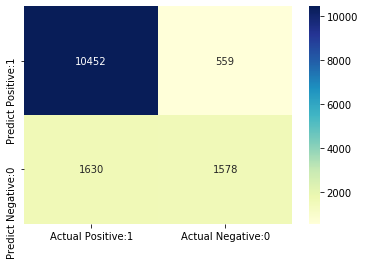

In [57]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [58]:
precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))
recall = TP / float(TP + FN)
print('Recall : {0:0.4f}'.format(recall))
f1score = 2 *( (precision * recall)/ (precision + recall))
print('F1-score : {0:0.4f}'.format(f1score))

Precision : 0.9492
Recall : 0.8651
F1-score : 0.9052


# Normalisation for Logistic Regression

In [73]:
min_max_scaler = preprocessing.MinMaxScaler()
normal_weather_df = min_max_scaler.fit_transform(weather_df)
column = weather_df.columns.tolist()
normal_weather_df = pd.DataFrame(normal_weather_df, columns=column)

In [74]:
X,y = normal_weather_df.iloc[:,normal_weather_df.columns != 'RainTomorrow'], normal_weather_df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [75]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.85
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     22098
         1.0       0.72      0.50      0.59      6341

    accuracy                           0.85     28439
   macro avg       0.80      0.72      0.75     28439
weighted avg       0.84      0.85      0.84     28439



In [76]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', TP)
print('\nTrue Negatives(TN) = ', TN )
print('\nFalse Positives(FP) = ', FP)
print('\nFalse Negatives(FN) = ', FN )

Confusion matrix

 [[20870  1228]
 [ 3157  3184]]

True Positives(TP) =  20870

True Negatives(TN) =  3184

False Positives(FP) =  1228

False Negatives(FN) =  3157


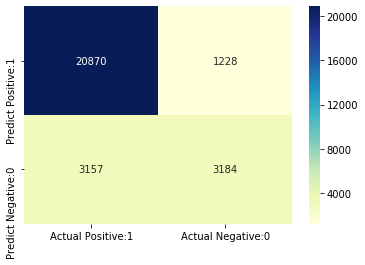

In [77]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [78]:
precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))
recall = TP / float(TP + FN)
print('Recall : {0:0.4f}'.format(recall))
f1score = 2 *( (precision * recall)/ (precision + recall))
print('F1-score : {0:0.4f}'.format(f1score))

Precision : 0.9444
Recall : 0.8686
F1-score : 0.9049


In [ ]:
pd.to_csv()